<a href="https://colab.research.google.com/github/pr-shukla/Pursuit-Evasion/blob/main/pursuit_evader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing required Libraries**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import math
from tensorflow.keras.utils import plot_model
import pydot
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pylab
!pip install pyyaml h5py

# Defining Paramters for Engagement of Pursuer and Evader 

In [2]:
#Dimension of State Space
dim_state = 3

#hidden_nodes = 3

#Time Difference Between 2 Steps
dt = 0.1

#Number of Episodes
num_episodes = 1000

#Number of Steps
num_steps = 400

#buffer_range = 60

#Minimum turing radius of Pursuer
rho = 1

#velocity of pursuer
v = 1.0


#Velocity of Evader during training
ve = 0.5

#angle between initial velocity and reference
te = 3*np.pi/4

# Defining Function to add random noise in actions to increase Exploration

In [3]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=0.1, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

# Defining class **Buffer** to sample minibatch randomly and to update actors and critic parameters

In [4]:
class Buffer:
    def __init__(self, buffer_capacity=10000, batch_size=64):

        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size
        #Buffer for critic / actor loss-function
        self.loss_critic = 0
        self.loss_actor = 0

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, dim_state))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, dim_state))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
            
            self.loss_critic = critic_loss

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)
            
            self.loss_actor = actor_loss

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        
    def get_list_critic(self):
        return self.loss_critic
    
    def get_list_actor(self):
        return self.loss_actor


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(tau):
    new_weights = []
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_critic.set_weights(new_weights)

    new_weights = []
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_actor.set_weights(new_weights)

# Creating Actor and Critic Model

In [5]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.00003, maxval=0.00003)

    inputs = layers.Input(shape=(dim_state,))
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(inputs)
    out = layers.Dropout(rate=0.5)(out )
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out )
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(inputs)
    out = layers.Dropout(rate=0.5)(out )
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out )
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs 
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    # State as input
    state_input = layers.Input(shape=(dim_state))
    state_out = layers.Dense(16, activation="selu", kernel_initializer="lecun_normal")(state_input)
    state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="selu", kernel_initializer="lecun_normal")(state_out)
    state_out = layers.BatchNormalization()(state_out)

    # Action as input
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="selu", kernel_initializer="lecun_normal")(action_input)
    action_out = layers.BatchNormalization()(action_out)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(concat)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

# Defining Function to Execute Actor Modelto generate actions

In [6]:
def policy(state, noise_object):
    
    sampled_actions = tf.squeeze(actor_model(state ))
    noise = noise_object()

    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1.0, 1.0)

    return [np.squeeze(legal_action)]

# Defining Hyperparameters

In [7]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
actor_model.summary()
plot_model(actor_model, to_file='actor_model.png')
critic_model = get_critic()
critic_model.summary()
plot_model(critic_model, to_file='critic_model.png')

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models cr 0.0001 ac 0.00005
critic_lr = 0.0001
actor_lr = 0.00005

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
# Discount factor for future rewards
gamma = 0.98
# Used to update target networks
tau = 0.01

buffer = Buffer(10000, 64)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024  

# Defining Functions for dynamics of Pursuit EVader Engagement

In [8]:
critic_lr = 0.00001
actor_lr = 0.000005

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

In [9]:
pi = np.pi
dt = 0.1


#cor0_e = [np.random.uniform(-3,3) , np.random.uniform(-1,5)] #начальные координаты цели x0_e, y0_e
cor0_p = [0, 0, pi/2]
w = 1
R = 1
phi0 = np.pi/7



def xEn(t, cor0):
    return R*np.cos(w*t + phi0) + cor0[0]

def yEn(t, cor0):
    return R*np.sin(w*t + phi0) + cor0[1]


# state[0] - x_p
# state[1] - y_p
# state[2] - угол поворота
# state[3] - x_e
# state[4] - y_e

In [10]:
def reward(state):
    r = -np.log(10 * leng(state)) - (leng(state))**2
    return r

def leng(state):
    length = (( state[0] - state [3])**2 + (state[1] - state[4])**2)**0.5
    #length = (state[1]**2 + state[0]**2)**0.5
    return length

def transition(state, u , t , cor0):
    new_state = (state[0] + np.cos(state[2]) * dt , state[1] + np.sin(state[2]) *dt, (state[2] + u*dt) % (2*np.pi) , xEn(t+dt, cor0), yEn(t+dt , cor0))
    #new_state = (state[0] + (-1 + u*state[0] + np.cos(state[2])) * dt, state[1] + (-u*state[1] + np.sin(state[2])) * dt,state[2] + (1 - u  ) * dt)
    
    # угол прямой соединящей P и Е относительно оси Х
    alpha_0 = angle(state)
    # угол от нового положения
    alpha = angle(new_state)
    #(фи - альфа) -> угол отклонения (радиальное отклонение) / фи - угол между скоростью и осью Х
    red_tet = new_state[2] - alpha
    #редуцированное пространство / второй член - угловая скорость
    red_state = (leng(state), (alpha-alpha_0)/dt, red_tet)
    return new_state, red_state

In [11]:
# угол между прямой соединящей (P и Е) и оси Х
def angle(state):
    return (math.atan2(state[4] - state[1],state[3] - state[0]) % (2*np.pi))


In [12]:
angle((0,0,pi/2 ,2, 3)) % (2*np.pi)

0.982793723247329

# Generating Episodes to train model
**Episodes during training may not appear very nice. But once the model get trained and when we excute that model in next cell you will see the better results**

The target has been captured
Episode * 0 * Avg Reward is ==> -403.00777285523486


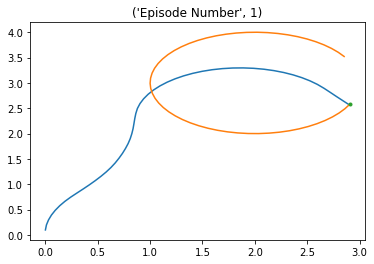

The target has been captured
Episode * 1 * Avg Reward is ==> -370.4912588876183


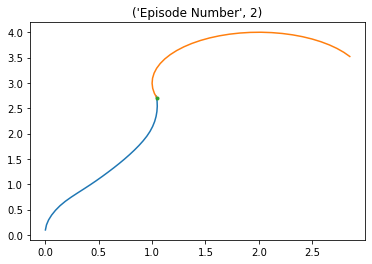

The target has been captured
Episode * 2 * Avg Reward is ==> -384.33062985191856


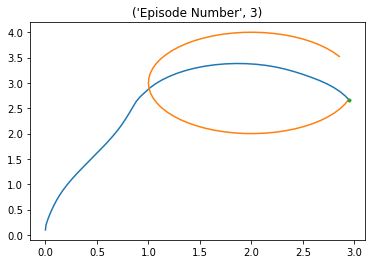

KeyboardInterrupt: 

In [52]:
ep_reward_list = []
ep_actor_loss_list = []
ep_critic_loss_list = []
# To store average reward history of last few episodes
avg_reward_list = []
#lists with actor's / critic's losses
critic_loss_list = []
actor_loss_list = []
terminal = 0.1
# Takes about 20 min to train
for ep in range(num_episodes):
    cor0 = (2 , 3)
    #w = np.random.uniform(-5,5)
    #R = np.random.uniform(0,5)
    sys_state = [0 , 0 , np.pi/2 , cor0[0] , cor0[1]]
    alpha = angle(sys_state)
    red_tet = sys_state[2] - alpha
    red_state = (leng(sys_state), 0, red_tet)
    episodic_reward = 0
    episodic_loss_actor = 0
    episodic_loss_critic = 0
    
    xc = []
    yc = []
    xce = []
    yce = []
    
    t = 0
    dt = 0.1
    #while True:
    for i in range(num_steps):
      if leng(sys_state) > terminal:
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(red_state), 0)

        action = policy(tf_prev_state, ou_noise)

        # Recieve state and reward from environment.
        new_state, new_red_state = transition(sys_state, float(action[0]), t, cor0)
        rew = reward(new_state)

        buffer.record((red_state , action, rew, new_red_state))
        episodic_reward += rew
        buffer.learn()
        #print(new_red_state)
        update_target(tau)
        
        actor_los = tf.reshape(buffer.get_list_actor(), []).numpy()
        critic_los = tf.reshape(buffer.get_list_critic(), []).numpy()
        
        episodic_loss_actor += actor_los
        episodic_loss_critic += critic_los
        
        t += dt
        red_state = new_red_state
        sys_state = new_state
        xc.append(sys_state[0])
        yc.append(sys_state[1])
        
        xce.append(sys_state[3])
        yce.append(sys_state[4])
      else:
        print('The target has been captured')
        break

 
        
    xc1 = [sys_state[3]]
    yc1 = [sys_state[4]]

    ep_reward_list.append(episodic_reward)
    
    ep_actor_loss_list.append(episodic_loss_actor)
    ep_critic_loss_list.append(episodic_loss_critic)
    
    # Mean of last 40 episodes
    avg_actor_loss = np.mean(ep_actor_loss_list[-num_episodes:])
    avg_critic_loss = np.mean(ep_critic_loss_list[-num_episodes:])
    
    critic_loss_list.append(avg_critic_loss)
    actor_loss_list.append(avg_actor_loss)
    
    avg_reward = np.mean(ep_reward_list[-num_episodes:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)
    plt.plot(xc,yc)
    plt.plot(xce,yce)
    plt.plot(xc1,yc1,'.')
    title = 'Episode Number', ep+1
    plt.title(title)
    plt.show()


In [ ]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [ ]:
plt.plot(actor_loss_list)
plt.title("Actor Loss")
plt.xlabel("Episode")
plt.ylabel("Value Actor Loss")
plt.show()

In [ ]:
plt.plot(critic_loss_list)
plt.title("Critic Loss")
plt.xlabel("Episode")
plt.ylabel("Value Critic Loss")
plt.show()

In [ ]:
#actor_model.load_weights('./checkpoints/lr_0.001')


In [13]:
#actor_model.save_weights('./checkpoints/lr_0.002')
actor_model.load_weights('./checkpoints/antica')

# Executing our trained model here to analyze how good the parameters are.

In [14]:
import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import numpy as np
from numpy import array, sin, cos, sqrt, arctan, arccos, arctan2, roots, append, real, pi, inf
import math
from scipy import integrate
from dubins.dubins.planar_reachable_set import x_RS, y_RS, x_LR, y_LR, V_CS, V_CC_minus, V_CC_plus

def arctg2(y, x):
    return (2 * (y >= 0) - 1) * arccos(x / sqrt(x ** 2 + y ** 2)) + 2 * (y < 0) * pi

In [15]:
# pos_vec = [[],[],[],[],[]] #задаем вектор, который будет содержать массивы движения машины Дубинса и цели

Vx_e, Vy_e = 0.5, 0.5 #скорость цели
V_e = sqrt(Vx_e ** 2 + Vy_e ** 2) #модуль скорости цели

ε = 0.001 #эпсилон для определения времени
cor0 = (1 ,1)
#cor0 = (np.random.uniform(-3,3) , np.random.uniform(-1,5)) #начальные координаты цели x0_e, y0_e (та же позиция, что и раньше)
cor0_e = cor0
cor0_p = [0, 0, pi/2] #начальные координаты машины Дубинса

V_p, U_p = 1, 1 #скорость машины Дубинса
t0, dt = 0, 0.01 #начальное время и шаг времени в анимации
#posP = array(cor0_p) #массив начальных координат машины Дубинса

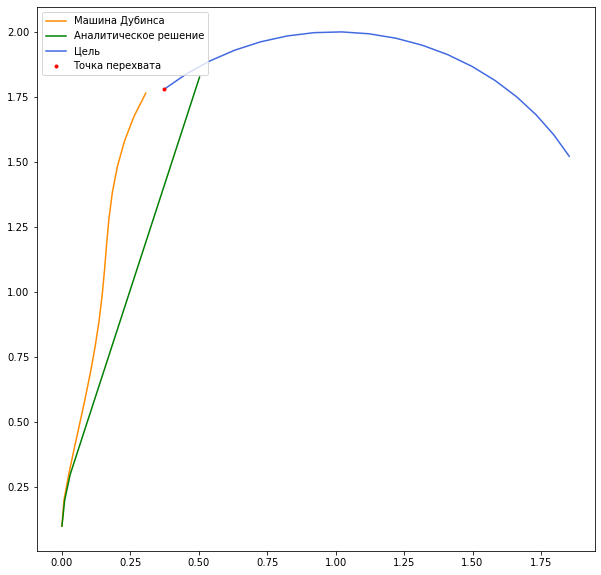

Optimal time: 1.8
NN time: 1.8


In [16]:
def xE(t):
    return R*np.cos(w*t + phi0) + cor0_e[0]

def yE(t):
    return R*np.sin(w*t + phi0) + cor0_e[1]

def ρB_CS(t, x, y):
    τ1 = (arctg2(y, 1-abs(x)) + arccos(1/sqrt((1-abs(x))**2 + y**2))) % (2*pi)
    τ2 = (arctg2(y, 1-abs(x)) - arccos(1/sqrt((1-abs(x))**2 + y**2))) % (2*pi)
    τ = array([τ1, τ2, 0, t])
    τ = τ[τ <= t]
    ρ = sqrt((abs(x) - x_RS(τ, t))**2 + (y - y_RS(τ, t))**2)
    return ρ.min()
def ρB_CC(t, x, y):
    a = -(y + sin(t/3))
    b = 3*(1+abs(x)) + cos(t/3)
    c = 3*y - sin(t/3)
    d = -(1+abs(x)) + cos(t/3)
    ξ = roots([a, b, c, d]) 
    τ = (t/3 - 2*arctan(real(ξ))) % (2*pi)
    τ = append(τ[τ <= t], [0, t])
    ρ = sqrt((abs(x) - x_LR(τ, t))**2 + (y - y_LR(τ, t))**2)
    return ρ.min()
def ρB(t, x, y):
    return min(ρB_CS(t, x, y), ρB_CC(t, x, y))
def convergent_estimate(t, xE, yE, v_max):
    t = t + ρB(t, xE(t), yE(t))/(1 + v_max)
    return t

def conv_est(t, xE, yE, v, ε):
    n = 0
    t_prev = float('-inf')
    δ = ε/(1 + v)
    while t - t_prev > δ:
        t_prev = t
        n += 1
        t = convergent_estimate(t, xE, yE, v)
    return n, t
N, T = conv_est(0, xE, yE, V_e, ε)
V_cs = V_CS(xE(T), yE(T))
V_cc_m = V_CC_minus(xE(T), yE(T))
V_cc_p = V_CC_plus(xE(T), yE(T))
def min_V(v_CS, v_CC_minus, v_CC_plus, T):
    V_CS_T = abs(v_CS - T)
    V_CC_minus_T = abs(v_CC_minus - T)
    V_CC_plus_T = abs(v_CC_plus - T)
    V_list = [V_CS_T, V_CC_minus_T, V_CC_plus_T]
    minor = V_list[0]
    for V in V_list:
        if V < minor:
            minor = V
    return V_list.index(minor)
def teta_CS_func(t):
    state = sqrt(abs((1 - abs(xE(t))) ** 2 + yE(t) ** 2 - 1)) #может быть под корнем отрицательное число!
    alfa_C = (1 - abs(xE(t)) + yE(t) * state) / (state ** 2 + 1)
    alfa_S = (yE(t) - (1 - abs(xE(t))) * state) / (state ** 2 + 1)
    if alfa_S >= 0:
        teta_CS = arccos(alfa_C)
    else:
        teta_CS = 2 * pi - arccos(alfa_C)
    return teta_CS

teta_CS_func(T)
def u_CS_func(t):
    teta_CS = teta_CS_func(T) #находим teta_CS от Т
    return np.where((t < teta_CS) & (xE(T) != 0), [-np.sign(xE(T))],
                    (np.where((t < teta_CS) & (xE(T) == 0), [1.], [0])))
    
def teta_CC_pol(t):
    alfa = (5 - (1 + abs(xE(t))) ** 2 - yE(t) ** 2) / 4
    return arccos(((1 + abs(xE(t))) * (2 - alfa) +
                               yE(t) * sqrt(1 - alfa ** 2))/((1 + abs(xE(t))) ** 2 + yE(t) ** 2))

def teta_CC_min(t):
    alfa = (5 - (1 + abs(xE(t))) ** 2 - yE(t) ** 2) / 4
    return arccos(((1 + abs(xE(t))) * (2 - alfa) -
                               yE(t) * sqrt(1 - alfa ** 2))/((1 + abs(xE(t))) ** 2 + yE(t) ** 2))
def u_CC_pol_func(t):
    teta_CC = teta_CC_pol(T) #находим teta_CC от Т
    return np.where((t < teta_CC) & (xE(T) != 0), [np.sign(xE(T))],
                    (np.where((t >= teta_CC) & (xE(T) != 0), [-np.sign(xE(T))],
                              (np.where((t < teta_CC) & (xE(T) == 0), [1.], [-1.])))))

def u_CC_min_func(t):
    teta_CC = teta_CC_min(T) #находим teta_CC от Т
    return np.where((t < teta_CC) & (xE(T) != 0), [np.sign(xE(T))],
                    (np.where((t >= teta_CC) & (xE(T) != 0), [-np.sign(xE(T))],
                              (np.where((t < teta_CC) & (xE(T) == 0), [1.], [-1.])))))
def u_opt(t0):
    index = min_V(V_cs, V_cc_m, V_cc_p, T)
    if index == 0:    
        return u_CS_func(t0)
    elif index == 1:
        return u_CC_min_func(t0)
    elif index == 2:
        return u_CC_pol_func(t0)
def compute_len(posP,posE):
    return sqrt((posP[0]-posE[0])**2+(posP[1]-posE[1])**2)

def policy_test(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy()
    return [sampled_actions]

pos_vec = [[],[],[],[],[]]
index = min_V(V_cs, V_cc_m, V_cc_p, T)
posP =  [0, 0, np.pi/2]
t0 = 0
dt  = 0.1
while t0 <= T:
    #print(posP)
    posE = [xE(t0), yE(t0)]
    #posE_arr = array(posE)
    #print(u_opt(t))
    velo = np.array([np.cos(posP[2]),np.sin(posP[2]),float(u_opt(t0))])
    posP = posP + velo*dt
    if compute_len(posP,posE)<=2*ε:
        print('ez_game')
    t0 += dt
    #posP_arr = array(posP)
    pos_vec[0].append(posP[0]) #xP
    pos_vec[1].append(posP[1]) #yP
#cor0 = (np.random.uniform(-10,10) , np.random.uniform(-10,10))
sys_state = [0 , 0 , np.pi/2 , cor0[0] , cor0[1]]
alpha = angle(sys_state)
red_tet = sys_state[2] - alpha
red_state = (leng(sys_state), 0, red_tet)
episodic_reward = 0
xc = []
yc = []
xce = []
yce = []
t = 0
dt = 0.1
#while True:
for i in range(num_steps):
    if leng(sys_state) > 0.1:
      tf_prev_state = tf.expand_dims(tf.convert_to_tensor(red_state), 0)
    
      action = policy_test(tf_prev_state, ou_noise)
        
      new_state, new_red_state = transition(sys_state, float(action[0]), t, cor0)
      rew = reward(new_state)
      t += dt
      red_state = new_red_state
      sys_state = new_state
      xc.append(sys_state[0])
      yc.append(sys_state[1])
        
      xce.append(sys_state[3])
      yce.append(sys_state[4])
    else:
      break
xc1 = [sys_state[3]]
yc1 = [sys_state[4]]



fig, ax = plt.subplots(figsize=(10, 10)) 

ax.plot(xc, yc, color = 'darkorange', label = 'Машина Дубинса')
ax.plot(pos_vec[0], pos_vec[1], color = 'green', label = 'Аналитическое решение')
ax.plot(xce, yce, color = 'royalblue', label = 'Цель')
#plt.title('Optimal trajectories')
ax.plot(xc1, yc1, '.', color = 'red', label = 'Точка перехвата')
ax.legend(loc = 'upper left')
plt.show() 


#plt.plot(xc,yc)
#plt.plot(xce,yce)
#plt.plot(pos_vec[0],pos_vec[1])
#plt.plot(xc1,yc1,'.')
#title = 'Сomparison of trajectories'
#plt.title(title)
#plt.show()
#print('Opt time:',len(np.array(pos_vec[0]))*0.1)
print('Optimal time:', round(T,1))
print('NN time:',len(xc)*0.1)